In [1]:
import os

os.chdir(os.path.join(os.getcwd(),'..'))
os.getcwd()

'/media/user/T7 Touch/Stage_Lucas/segmentation'

In [2]:
from src.nets import UNet
from src.downloads import download_data, unzip_data
from src.datasets import UNet_Segmentation_Dataset, MaskRCNN_Segmentation_Dataset
from src.training import train_UNet, train_MaskRCNN
from src.segmentation import post_processing
from src.visualization import plot_mini_batch
from src.processing import processChallenge, normalize_images

import numpy as np
import tifffile as tiff
import cv2
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from sklearn.model_selection import train_test_split
import albumentations as alb

In [3]:
names = ['Fluo-N2DH-GOWT1', 'Fluo-C2DL-MSC', 'Warwick QU']
models = ['UNet', 'FCN', 'DeepLab', 'MaskRCNN']

NAME = names[0]
CHANNELS = 3
NORMALIZED = False
# SHAPE = (346,512) # Warwick
# SHAPE = (640,640) # Gowt1
# SHAPE = (480,640) # MSC
# SHAPE = (600,600) # MSC
SHAPE = None
TRANSFORMS = None

DATASET = MaskRCNN_Segmentation_Dataset
BATCH_SIZE = 4

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

MODEL_NAME = models[3]
if MODEL_NAME == 'UNet':
    MODEL = UNet(CHANNELS, 64, 2)
    PARAMS = MODEL.parameters()

elif MODEL_NAME == 'MaskRCNN':
    MODEL = torchvision.models.detection.maskrcnn_resnet50_fpn(weights = "MaskRCNN_ResNet50_FPN_Weights.DEFAULT")
    in_features = MODEL.roi_heads.box_predictor.cls_score.in_features
    MODEL.roi_heads.box_predictor = FastRCNNPredictor(in_features , 2)
    in_features_mask = MODEL.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    MODEL.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask , hidden_layer , 2)

    PARAMS = [p for p in MODEL.parameters() if p.requires_grad]

    def custom(batch):
        imgs = [item[0] for item in batch]
        targ = [item[1] for item in batch]

        return [imgs, targ]

elif MODEL_NAME == 'FCN':
    MODEL = torchvision.models.segmentation.fcn_resnet101(weights='FCN_ResNet101_Weights.DEFAULT')
    MODEL.backbone['conv1'] = torch.nn.Conv2d(CHANNELS, 64, kernel_size=7, stride=2, padding=3, bias=False)
    MODEL.classifier[4] = torch.nn.Conv2d(512, 2, kernel_size=1)
    
    PARAMS = MODEL.parameters()

elif MODEL_NAME == 'DeepLab':
    MODEL = torchvision.models.segmentation.deeplabv3_resnet101(weights='DeepLabV3_ResNet101_Weights.DEFAULT')
    # MODEL = torchvision.models.segmentation.deeplabv3_resnet101(weights=False)
    MODEL.backbone['conv1'] = torch.nn.Conv2d(CHANNELS, 64, kernel_size=7, stride=2, padding=3, bias=False)
    MODEL.classifier[4] = torch.nn.Conv2d(256, 2, kernel_size=1)
    # MODEL.aux_classifier[4] = torch.nn.Conv2d(256, 2, kernel_size=1)

    PARAMS = MODEL.parameters()
    
else:
    print("Wrong model")

LR = 0.005
MM = 0.95
WD = 1e-4
EPOCHS = 25
STORE = 1
OPTIM = torch.optim.SGD(PARAMS, LR, MM, WD)
TRAINER = train_MaskRCNN

# processChallenge('/media/user/T7 Touch/Stage_Lucas/segmentation/data/external/2D/Cell Challenge/train/Fluo-N2DH-GOWT1', 'train')
# processChallenge('/media/user/T7 Touch/Stage_Lucas/segmentation/data/external/2D/Cell Challenge/test/Fluo-N2DH-GOWT1', 'test')

# normalize_images(f'Cell Challenge/train/{NAME}', CHANNELS)
# normalize_images(f'Cell Challenge/test/{NAME}', CHANNELS)

# img_path = "/media/user/T7 Touch/Stage_Lucas/segmentation/data/external/2D/Cell Challenge/train/Fluo-C2DL-MSC/02"
# mask_path = "/media/user/T7 Touch/Stage_Lucas/segmentation/data/external/2D/Cell Challenge/train/Fluo-C2DL-MSC/02_ST/SEG"

Train = DATASET(f'Cell Challenge/train/{NAME}', None, None, 'train', CHANNELS, NORMALIZED, SHAPE, TRANSFORMS)
Cell_train, Cell_val = random_split(Train, [0.8, 0.2])

if MODEL_NAME == 'MaskRCNN':
    train_loader = DataLoader(Cell_train, BATCH_SIZE, shuffle=True, collate_fn=custom)
    val_loader = DataLoader(Cell_val, BATCH_SIZE, shuffle=True, collate_fn=custom)

else:
    train_loader = DataLoader(Cell_train, BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(Cell_val, BATCH_SIZE, shuffle=True)

cuda


In [4]:
train_loss, val_loss, dices, ious = TRAINER(MODEL, DEVICE, OPTIM, train_loader, val_loader, None, None, EPOCHS)

Epoch: 1/25, Train loss: 0.7539, Val loss: 0.3102, Dice: 0.823, IoU: 0.6993
Epoch: 2/25, Train loss: 0.2512, Val loss: 0.2121, Dice: 0.846, IoU: 0.7331
Epoch: 3/25, Train loss: 0.2102, Val loss: 0.2024, Dice: 0.8541, IoU: 0.7453
Epoch: 4/25, Train loss: 0.1749, Val loss: 0.1728, Dice: 0.8463, IoU: 0.7336
Epoch: 5/25, Train loss: 0.1535, Val loss: 0.1609, Dice: 0.8505, IoU: 0.7399
Epoch: 6/25, Train loss: 0.1460, Val loss: 0.1539, Dice: 0.8522, IoU: 0.7425
Epoch: 7/25, Train loss: 0.1382, Val loss: 0.1483, Dice: 0.8458, IoU: 0.7328
Epoch: 8/25, Train loss: 0.1301, Val loss: 0.1463, Dice: 0.846, IoU: 0.7331
Epoch: 9/25, Train loss: 0.1268, Val loss: 0.1422, Dice: 0.8406, IoU: 0.7251
Epoch: 10/25, Train loss: 0.1240, Val loss: 0.1421, Dice: 0.8503, IoU: 0.7396
Epoch: 11/25, Train loss: 0.1219, Val loss: 0.1368, Dice: 0.8496, IoU: 0.7385
Epoch: 12/25, Train loss: 0.1156, Val loss: 0.1292, Dice: 0.8539, IoU: 0.745
Epoch: 13/25, Train loss: 0.1112, Val loss: 0.1394, Dice: 0.8592, IoU: 0.7531

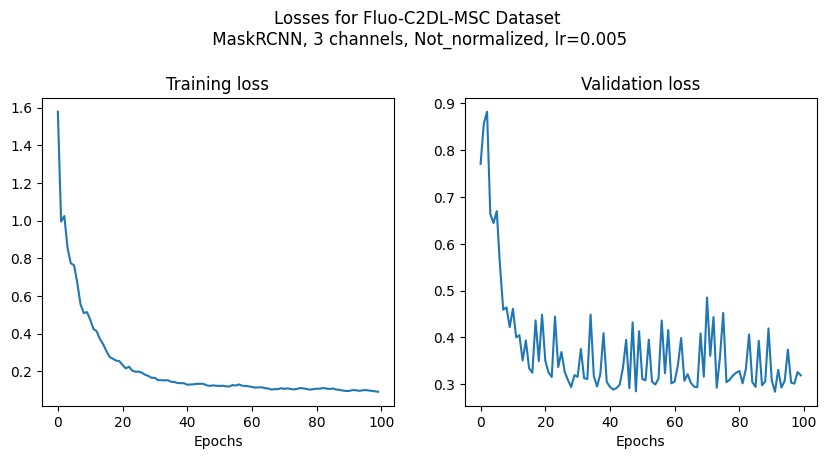

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(train_loss)
ax2.plot(val_loss)

ax1.set_title('Training loss')
ax2.set_title('Validation loss')

ax1.set_xlabel('Epochs')
ax2.set_xlabel('Epochs')

if NORMALIZED:
    NORMALIZED = 'Normalized'
else:
    NORMALIZED = 'Not_normalized'

if SHAPE == None:
    SHAPE = (782, 1200)

fig.suptitle(f'Losses for {NAME} Dataset\n {MODEL_NAME}, {CHANNELS} channels, {NORMALIZED}, lr={LR}', y=1.1);
# plt.savefig(f'experiments/{cell_type}_{CHANNELS}C_{NORMALIZED}.png')

dic = {'train_loss': train_loss, 'val_loss': val_loss, 'dice': dices, 'IoU': ious}
df = pd.DataFrame(dic)
df.to_csv(f'experiments/{MODEL_NAME}_{NAME}_{CHANNELS}C_{NORMALIZED}_{SHAPE[0]}_{SHAPE[1]}.csv')

torch.save(MODEL.state_dict(), f'models/{MODEL_NAME}_{NAME}_{CHANNELS}C_{NORMALIZED}_{SHAPE[0]}_{SHAPE[1]}.pth')

In [9]:
Test = DATASET(f'Cell Challenge/test/{NAME}', 'test', CHANNELS, False, SHAPE, None)
test_loader = DataLoader(Test, BATCH_SIZE, shuffle=False)

In [12]:
imgs_test = next(iter(test_loader))
imgs_test.shape

torch.Size([4, 3, 1024, 1024])

In [ ]:
imgs_test = next(iter(test_loader))
batch = [img.to(DEVICE) for img in imgs_test]
MODEL.eval()
preds = np.zeros((BATCH_SIZE, 1, 1024, 1024))
with torch.no_grad():
    outs = MODEL(batch)

for i,out in enumerate(outs):
    mask = torch.sum(out['masks'], (0,1))
    print(np.unique(out['masks'].cpu()))
    preds[i] = mask.cpu()

plot_mini_batch(imgs_test[:,0,:,:].cpu(), preds[:,0,:,:], False, 4)

In [ ]:
imgs_test = next(iter(test_loader))
imgs_test = imgs_test.to(DEVICE, dtype=torch.float32)
MODEL.eval()
with torch.no_grad():
    scores = MODEL(imgs_test)['out']
    preds = torch.argmax(scores, dim=1).float()

plot_mini_batch(imgs_test.squeeze(1).cpu(), preds.cpu(), False, 5)